In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
from scipy.sparse import load_npz
from sklearn.tree import DecisionTreeClassifier
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Conv1D, GlobalMaxPooling1D, MaxPooling1D,
    Input, Bidirectional, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
fake_path = "/content/drive/MyDrive/archive/Fake.csv"
true_path = "/content/drive/MyDrive/archive/True.csv"

fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
print("Real news" ,true_df.shape)
print("Fake news" ,fake_df.shape)

Real news (21417, 4)
Fake news (23481, 4)


In [ ]:
fake_df["label"] = 1
true_df["label"] = 0

In [ ]:
merged_df = pd.concat([fake_df, true_df], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
merged_df["label"].value_counts()

,count
label,
1,23481
0,21417


<Axes: xlabel='label'>

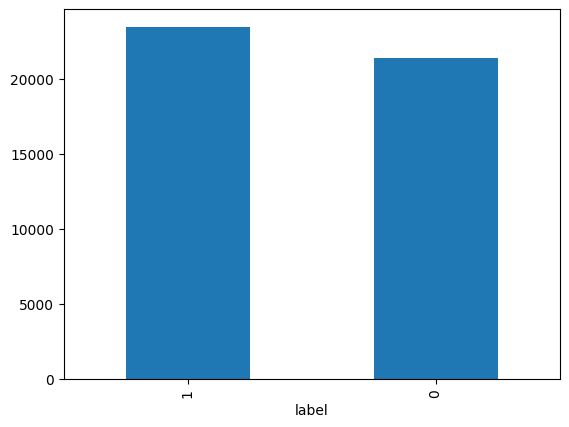

In [ ]:
merged_df['label'].value_counts().plot(kind='bar')

In [ ]:
merged_df.info()
merged_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
#to check null values
print(merged_df.isnull().sum())

#to check for empty strings
empty_text = merged_df[merged_df["text"].str.strip().eq("")]
print("Text rows that are empty:", len(empty_text))

title      0
text       0
subject    0
date       0
label      0
dtype: int64
Text rows that are empty: 631


In [ ]:
# Check how many duplicate rows there are in 'text'
print("Rows with Duplicate texts:", merged_df["text"].duplicated().sum())

Rows with Duplicate texts: 6252


In [ ]:
# Drop rows where text is empty after stripping spaces
merged_df = merged_df[merged_df["text"].str.strip() != ""]

print("Remaining rows:", len(merged_df))

Remaining rows: 44267


In [ ]:
merged_df["content"] = merged_df["title"] + " " + merged_df["text"]

In [ ]:
# Remove duplicates in the combined content column
before = len(merged_df)
merged_df = merged_df.drop_duplicates(subset="content", keep="first")
after = len(merged_df)

print(f"Rows before duplicates: {before}")
print(f"Rows after duplicates: {after}")
print(f"Removed: {before - after} duplicates")

Rows before duplicates: 44267
Rows after duplicates: 38658
Removed: 5609 duplicates


In [ ]:
print("Remaining duplicates in content:", merged_df["content"].duplicated().sum())

Remaining duplicates in content: 0


In [ ]:
print("Empty rows left in content:", (merged_df["content"].str.strip() == "").sum())

Empty rows left in content: 0


In [ ]:
print(f"Final dataset has: {len(merged_df):,} articles")
print(f"  Real (0): {(merged_df['label']==0).sum():,}")
print(f"  Fake (1): {(merged_df['label']==1).sum():,}")

Final dataset has: 38,658 articles
  Real (0): 21,196
  Fake (1): 17,462


In [ ]:
merged_df["text_len"] = merged_df["content"].apply(lambda x: len(x.split()))
merged_df["clean_word_count"] = merged_df["text_len"]  #update after cleaning

print(f"\nBefore Preprocessing:")
print(f"Average words per article: {merged_df['text_len'].mean():.1f}")
print(f"Median: {merged_df['text_len'].median():.1f}")
print(f"Min: {merged_df['text_len'].min()}")
print(f"Max: {merged_df['text_len'].max()}")

print(f"\nReal articles avg: {merged_df[merged_df['label']==0]['text_len'].mean():.1f} words")
print(f"Fake articles avg: {merged_df[merged_df['label']==1]['text_len'].mean():.1f} words")


Before Preprocessing:
Average words per article: 415.1
Median: 381.0
Min: 2
Max: 8148

Real articles avg: 394.8 words
Fake articles avg: 439.6 words


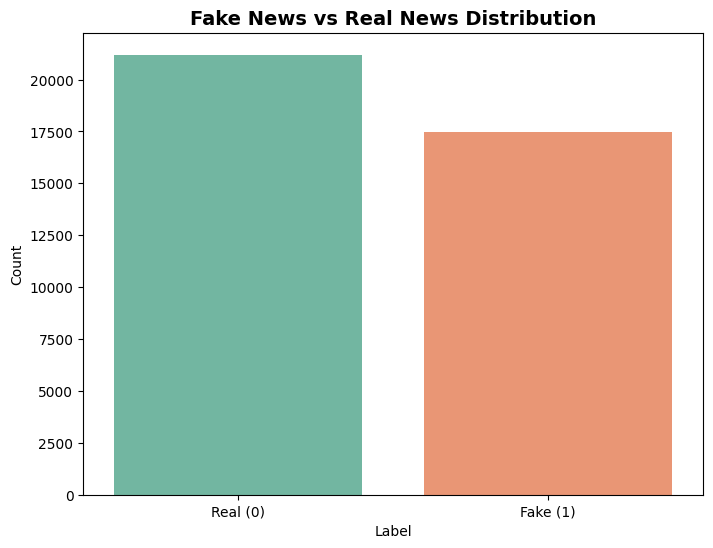

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=merged_df, palette="Set2")
plt.xticks([0, 1], ["Real (0)", "Fake (1)"])
plt.title("Fake News vs Real News Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Label")
plt.ylabel("Count")
plt.savefig('/content/drive/MyDrive/archive/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

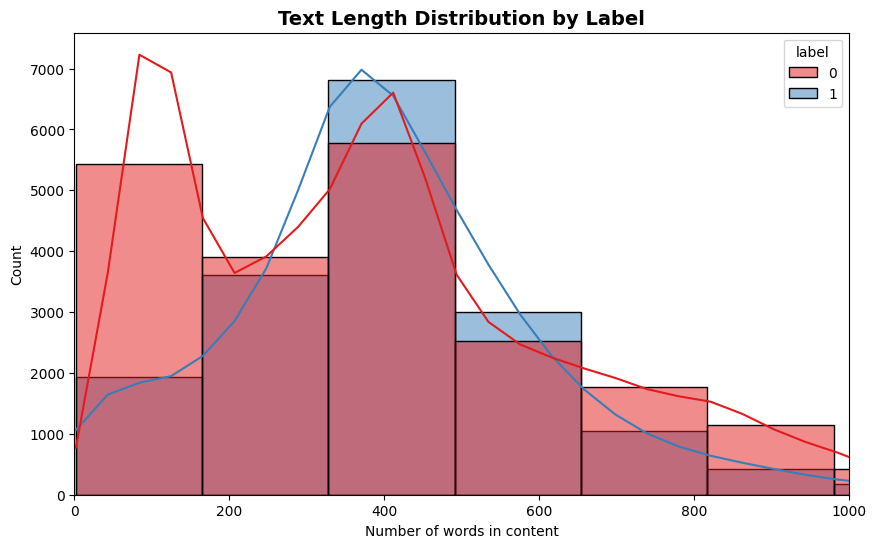

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x="text_len", hue="label", bins=50, kde=True, palette="Set1")
plt.title("Text Length Distribution by Label", fontsize=14, fontweight='bold')
plt.xlabel("Number of words in content")
plt.ylabel("Count")
plt.xlim(0, 1000)
plt.savefig('/content/drive/MyDrive/archive/text_length_dist.png', dpi=300, bbox_inches='tight')
plt.show()

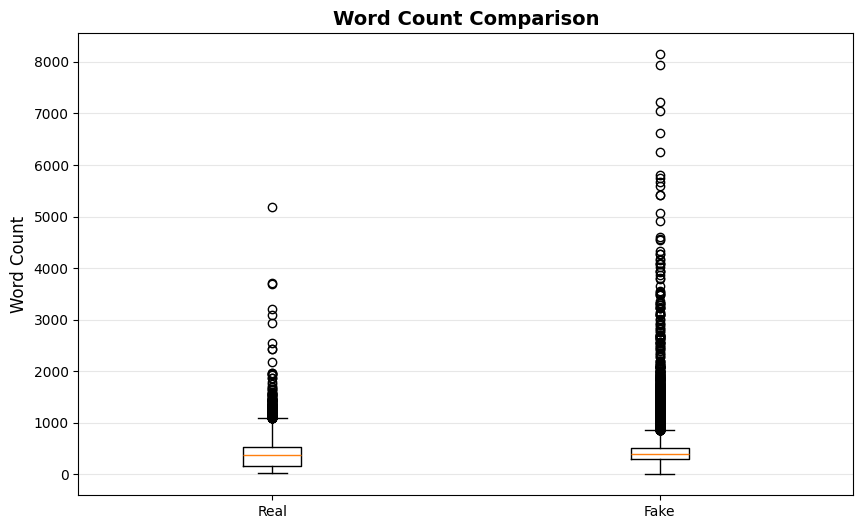

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
real_words = merged_df[merged_df['label'] == 0]['text_len']
fake_words = merged_df[merged_df['label'] == 1]['text_len']

ax.boxplot([real_words, fake_words], labels=['Real', 'Fake'])
ax.set_ylabel('Word Count', fontsize=12)
ax.set_title('Word Count Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.savefig('/content/drive/MyDrive/archive/word_count_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_path = "/content/drive/MyDrive/archive/cleaned_fake_news.csv"
merged_df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved successfully to: {output_path}")

Cleaned dataset saved successfully to: /content/drive/MyDrive/archive/cleaned_fake_news.csv


In [ ]:
merged_df["label"].value_counts()

,count
label,
0,21196
1,17462


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/archive/cleaned_fake_news.csv')
print(f"Loaded dataset: {len(df):,} articles")
print(f"Columns: {df.columns.tolist()}")

Loaded dataset: 38,658 articles
Columns: ['title', 'text', 'subject', 'date', 'label', 'content', 'text_len', 'clean_word_count']


In [ ]:
#downloading NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    """Remove noise URLs, punctuation, stopwords; lemmatize words"""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

In [ ]:
#Apply preprocessing
merged_df['clean_text'] = merged_df['content'].apply(clean_text)
merged_df['clean_word_count'] = merged_df['clean_text'].apply(lambda x: len(x.split()))

In [ ]:
before_filter = len(merged_df)
# Remove articles with less than 10 words after cleaning
merged_df = merged_df[merged_df['clean_word_count'] >= 10].reset_index(drop=True)
after_filter = len(merged_df)
removed = before_filter - after_filter

print(f"Removed {removed:,} articles with <10 words after cleaning")
print(f"Final dataset: {len(merged_df):,} articles")
print(f"Real (0): {(merged_df['label']==0).sum():,}")
print(f"Fake (1): {(merged_df['label']==1).sum():,}")

Removed 33 articles with <10 words after cleaning
Final dataset: 38,625 articles
Real (0): 21,196
Fake (1): 17,429


In [ ]:
empty_clean = (merged_df['clean_text'].str.strip() == '').sum()
very_short = (merged_df['clean_word_count'] < 5).sum()

print(f"\nEmpty cleaned texts: {empty_clean}")
print(f"Very short texts (<5 words): {very_short}")
print(f"Missing values: {merged_df[['clean_text', 'label']].isnull().sum().sum()}")


Empty cleaned texts: 0
Very short texts (<5 words): 0
Missing values: 0


In [ ]:
output_dir = '/content/drive/MyDrive/archive'
# Save full dataset all columns
full_path = f'{output_dir}/preprocessed_full.csv'
merged_df.to_csv(full_path, index=False)
print(f"Saved: preprocessed_full.csv")
print(f"Location: {full_path}")
print(f"Size: {len(merged_df):,} rows × {len(merged_df.columns)} columns")

# Save compact dataset only clean_text and label for modeling
compact_path = f'{output_dir}/preprocessed_compact.csv'
merged_df[['clean_text', 'label']].to_csv(compact_path, index=False)
print(f"Saved: preprocessed_compact.csv")
print(f"Location: {compact_path}")
print(f"Size: {len(merged_df):,} rows × 2 columns")
print(f"Columns: ['clean_text', 'label']")

Saved: preprocessed_full.csv
Location: /content/drive/MyDrive/archive/preprocessed_full.csv
Size: 38,625 rows × 9 columns
Saved: preprocessed_compact.csv
Location: /content/drive/MyDrive/archive/preprocessed_compact.csv
Size: 38,625 rows × 2 columns
Columns: ['clean_text', 'label']


In [ ]:
print(f"Data in memory: {len(merged_df):,} articles")
print(f"Real (0): {(merged_df['label']==0).sum():,}")
print(f"Fake (1): {(merged_df['label']==1).sum():,}")

Data in memory: 38,625 articles
Real (0): 21,196
Fake (1): 17,429


In [ ]:
X = merged_df['clean_text'].values
y = merged_df['label'].values

In [ ]:
#Train-Test Split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
#Creating Validation Split from Train
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [ ]:
#Applying TF-IDF Vectorization for SVM and Decision Tree
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)
# Fit on training data and transform all sets
X_train_tfidf = tfidf.fit_transform(X_train_final)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Results:")
print(f"Vocabulary size: {len(tfidf.vocabulary_):,} words")
print(f"Train matrix shape: {X_train_tfidf.shape}")
print(f"Val matrix shape: {X_val_tfidf.shape}")
print(f"Test matrix shape: {X_test_tfidf.shape}")

# Show top features
feature_names = tfidf.get_feature_names_out()
print(f"Sample features: {list(feature_names[:10])}")

TF-IDF Results:
Vocabulary size: 5,000 words
Train matrix shape: (24720, 5000)
Val matrix shape: (6180, 5000)
Test matrix shape: (7725, 5000)
Sample features: ['abandon', 'abandoned', 'abbas', 'abc', 'abc news', 'abdullah', 'abe', 'ability', 'able', 'abortion']


In [ ]:
#Creating Tokenized Sequences for LSTM
# Initialize tokenizer
tokenizer = Tokenizer(
    num_words=5000,
    oov_token='<OOV>'
)

# Fit on training data
print("Fitting tokenizer on training data")
tokenizer.fit_on_texts(X_train_final)

print(f"Vocabulary size: {len(tokenizer.word_index):,} words")

# Convert text to sequences
print("Converting text to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train_final)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine max sequence length
max_length = 200

print(f"Sequence Parameters:")
print(f"Max sequence length: {max_length}")

# Calculate actual lengths
train_lengths = [len(seq) for seq in X_train_seq]
print(f"Avg train sequence length: {np.mean(train_lengths):.1f}")
print(f"Max train sequence length: {max(train_lengths)}")

# Pad sequences
print("Padding sequences...")
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print("Padded Sequence Shapes:")
print(f"Train: {X_train_pad.shape}")
print(f"Val:   {X_val_pad.shape}")
print(f"Test:  {X_test_pad.shape}")

Fitting tokenizer on training data
Vocabulary size: 148,153 words
Converting text to sequences...
Sequence Parameters:
Max sequence length: 200
Avg train sequence length: 233.1
Max train sequence length: 4787
Padding sequences...
Padded Sequence Shapes:
Train: (24720, 200)
Val:   (6180, 200)
Test:  (7725, 200)


In [ ]:
#Saving Processed Data
output_dir = '/content/drive/MyDrive/archive'

# Save labels
np.save(os.path.join(output_dir, 'y_train.npy'), y_train_final)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

# Save TF-IDF data sparse format
from scipy.sparse import save_npz
save_npz(os.path.join(output_dir, 'X_train_tfidf.npz'), X_train_tfidf)
save_npz(os.path.join(output_dir, 'X_val_tfidf.npz'), X_val_tfidf)
save_npz(os.path.join(output_dir, 'X_test_tfidf.npz'), X_test_tfidf)

# Save TF-IDF vectorizer
with open(os.path.join(output_dir, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(tfidf, f)

# Save padded sequences for LSTM
np.save(os.path.join(output_dir, 'X_train_pad.npy'), X_train_pad)
np.save(os.path.join(output_dir, 'X_val_pad.npy'), X_val_pad)
np.save(os.path.join(output_dir, 'X_test_pad.npy'), X_test_pad)

# Save tokenizer
with open(os.path.join(output_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

# Save text data for reference
np.save(os.path.join(output_dir, 'X_train_text.npy'), X_train_final)
np.save(os.path.join(output_dir, 'X_val_text.npy'), X_val)
np.save(os.path.join(output_dir, 'X_test_text.npy'), X_test)

In [ ]:
output_dir = '/content/drive/MyDrive/archive'
#Loading TF-IDF features
X_train = load_npz(f'{output_dir}/X_train_tfidf.npz')
X_val = load_npz(f'{output_dir}/X_val_tfidf.npz')
X_test = load_npz(f'{output_dir}/X_test_tfidf.npz')

In [ ]:
#Loading labels
y_train_final = np.load(f'{output_dir}/y_train.npy')
y_val = np.load(f'{output_dir}/y_val.npy')
y_test = np.load(f'{output_dir}/y_test.npy')

In [ ]:
svm = LinearSVC(
    C=1.0,
    max_iter=1000,
    random_state=42
)

In [ ]:
print(f"  Input: {X_train_tfidf.shape[0]:,} articles")
print(f"  Features: {X_train_tfidf.shape[1]:,} TF-IDF values per article")
print(f"  Labels: {len(y_train):,} labels (0=Real, 1=Fake)")

  Input: 24,720 articles
  Features: 5,000 TF-IDF values per article
  Labels: 30,900 labels (0=Real, 1=Fake)


In [ ]:
start_time = time.time()

In [ ]:
svm.fit(X_train_tfidf, y_train_final)
svm_train_time = time.time() - start_time

In [ ]:
print(f"SVM Time: {svm_train_time:.2f} seconds")

In [ ]:
y_pred = svm.predict(X_test_tfidf)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"RESULTS:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed report
print(f"Classification Report:")
print(classification_report(y_test, y_pred,
                           target_names=['Real (0)', 'Fake (1)']))

RESULTS:
Accuracy: 0.9939 (99.39%)
Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.99      1.00      0.99      4239
    Fake (1)       1.00      0.99      0.99      3486

    accuracy                           0.99      7725
   macro avg       0.99      0.99      0.99      7725
weighted avg       0.99      0.99      0.99      7725



In [ ]:
# Initialize Decision Tree
dt = DecisionTreeClassifier(
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

In [ ]:
start_time = time.time()

In [ ]:
dt.fit(X_train_tfidf, y_train_final)

dt_train_time = time.time() - start_time

In [ ]:
print(f"DT Time: {dt_train_time:.2f} seconds")

In [ ]:
start_inference_time = time.time()
y_pred_dt = dt.predict(X_test_tfidf)
inference_time = time.time() - start_inference_time

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_cm = confusion_matrix(y_test, y_pred_dt)

In [ ]:
print(f"\nMetrics:")
print(f"Accuracy:  {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
# Detailed report
print(f"Classification Report:")
print(classification_report(y_test, y_pred_dt,
                           target_names=['Real (0)', 'Fake (1)']))


Metrics:
Accuracy:  0.9965 (99.65%)
Precision: 0.9974
Recall:    0.9948
F1-Score:  0.9961
Classification Report:
              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      4239
    Fake (1)       1.00      0.99      1.00      3486

    accuracy                           1.00      7725
   macro avg       1.00      1.00      1.00      7725
weighted avg       1.00      1.00      1.00      7725



In [ ]:
output_dir = '/content/drive/MyDrive/archive'

In [ ]:
#Comparison Table

# Calculate SVM metrics
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

# DT metrics
# Create comparison DataFrame
comparison_data = {
    'Model': ['SVM (LinearSVC)', 'Decision Tree'],
    'Accuracy (%)': [round(svm_accuracy * 100, 2), round(dt_accuracy * 100, 2)],
    'Precision (%)': [round(svm_precision * 100, 2), round(dt_precision * 100, 2)],
    'Recall (%)': [round(svm_recall * 100, 2), round(dt_recall * 100, 2)],
    'F1-Score (%)': [round(svm_f1 * 100, 2), round(dt_f1 * 100, 2)]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

In [ ]:
comparison_df.style.set_caption("Model Performance Comparison")

,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
Model,,,,
SVM (LinearSVC),99.390000,99.620000,99.020000,99.320000
Decision Tree,99.650000,99.740000,99.480000,99.610000


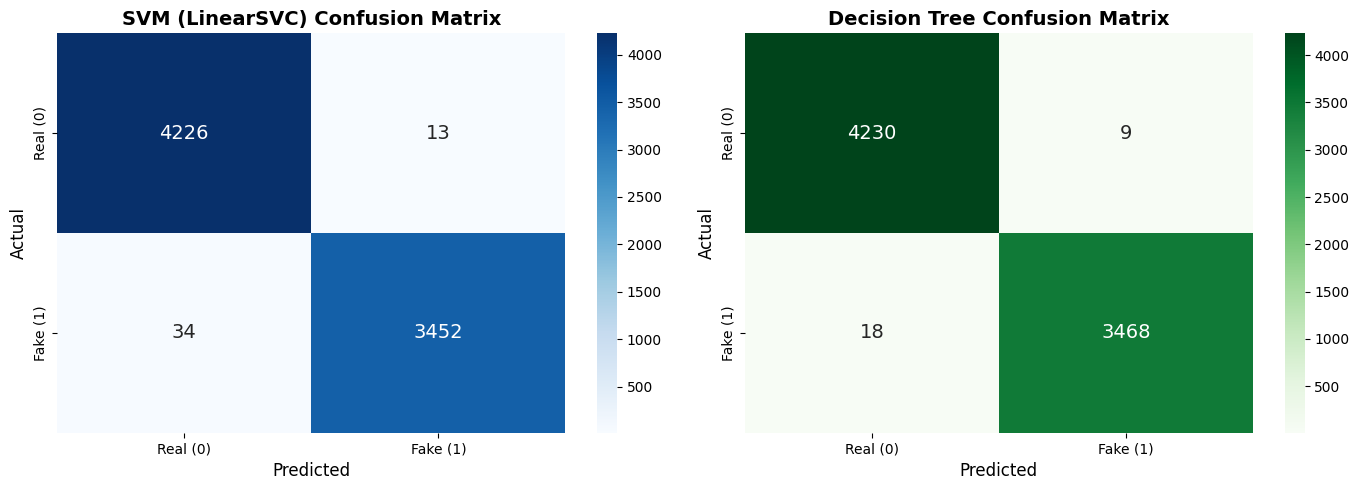

In [ ]:
# Get confusion matrices
cm_svm = confusion_matrix(y_test, y_pred)
cm_dt = confusion_matrix(y_test, y_pred_dt)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            annot_kws={'size': 14})
axes[0].set_title('SVM (LinearSVC) Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            annot_kws={'size': 14})
axes[1].set_title('Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from tabulate import tabulate
def analyze_errors(cm, model_name):
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    fpr = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0

    print(f"\n  {model_name} Error Analysis")
    print(f"  True Negatives  (Real classified as Real):  {tn:,}")
    print(f"  True Positives  (Fake classified as Fake):  {tp:,}")
    print(f"  False Positives (Real classified as Fake):  {fp:,}")
    print(f"  False Negatives (Fake classified as Real):  {fn:,}")
    print(f"  False Positive Rate: {fpr:.2f}%")
    print(f"  False Negative Rate: {fnr:.2f}%")

    return {
        'Model': model_name,
        'TN': tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'FP Rate (%)': round(fpr, 2),
        'FN Rate (%)': round(fnr, 2)
    }

# Run analysis
svm_errors = analyze_errors(cm_svm, 'SVM (LinearSVC)')
dt_errors = analyze_errors(cm_dt, 'Decision Tree')

# Create summary table
error_df = pd.DataFrame([svm_errors, dt_errors]).set_index('Model')

print("\n" + "="*60)
print("  COMPARATIVE ERROR ANALYSIS SUMMARY")
print("="*60)
print(tabulate(error_df, headers='keys', tablefmt='fancy_grid'))


  SVM (LinearSVC) Error Analysis
  True Negatives  (Real classified as Real):  4,226
  True Positives  (Fake classified as Fake):  3,452
  False Positives (Real classified as Fake):  13
  False Negatives (Fake classified as Real):  34
  False Positive Rate: 0.31%
  False Negative Rate: 0.98%

  Decision Tree Error Analysis
  True Negatives  (Real classified as Real):  4,230
  True Positives  (Fake classified as Fake):  3,468
  False Positives (Real classified as Fake):  9
  False Negatives (Fake classified as Real):  18
  False Positive Rate: 0.21%
  False Negative Rate: 0.52%

  COMPARATIVE ERROR ANALYSIS SUMMARY
╒═════════════════╤══════╤══════╤══════╤══════╤═══════════════╤═══════════════╕
│ Model           │   TN │   TP │   FP │   FN │   FP Rate (%) │   FN Rate (%) │
╞═════════════════╪══════╪══════╪══════╪══════╪═══════════════╪═══════════════╡
│ SVM (LinearSVC) │ 4226 │ 3452 │   13 │   34 │          0.31 │          0.98 │
├─────────────────┼──────┼──────┼──────┼──────┼──────────

In [ ]:
#Saving trained models

# Save SVM model
with open(f'{output_dir}/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
print(f"SVM model saved: {output_dir}/svm_model.pkl")

# Save Decision Tree model
with open(f'{output_dir}/dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)
print(f"decision Tree model saved: {output_dir}/dt_model.pkl")

# TF-IDF vectorizer
print(f"TF-IDF vectorizer already at: {output_dir}/tfidf_vectorizer.pkl")

SVM model saved: /content/drive/MyDrive/archive/svm_model.pkl
decision Tree model saved: /content/drive/MyDrive/archive/dt_model.pkl
TF-IDF vectorizer already at: /content/drive/MyDrive/archive/tfidf_vectorizer.pkl


In [ ]:
#Saving results to csv
# Save comparison table
comparison_df.to_csv(f'{output_dir}/model_comparison.csv')
print(f"Model comparison: {output_dir}/model_comparison.csv")

# Save error analysis
error_df.to_csv(f'{output_dir}/error_analysis.csv')
print(f"Error analysis: {output_dir}/error_analysis.csv")

# Save detailed classification reports
svm_report = classification_report(y_test, y_pred, output_dict=True)
dt_report = classification_report(y_test, y_pred_dt, output_dict=True)

svm_report_df = pd.DataFrame(svm_report).transpose()
dt_report_df = pd.DataFrame(dt_report).transpose()

svm_report_df.to_csv(f'{output_dir}/svm_classification_report.csv')
dt_report_df.to_csv(f'{output_dir}/dt_classification_report.csv')
print(f"SVM report: {output_dir}/svm_classification_report.csv")
print(f"DT report: {output_dir}/dt_classification_report.csv")

Model comparison: /content/drive/MyDrive/archive/model_comparison.csv
Error analysis: /content/drive/MyDrive/archive/error_analysis.csv
SVM report: /content/drive/MyDrive/archive/svm_classification_report.csv
DT report: /content/drive/MyDrive/archive/dt_classification_report.csv


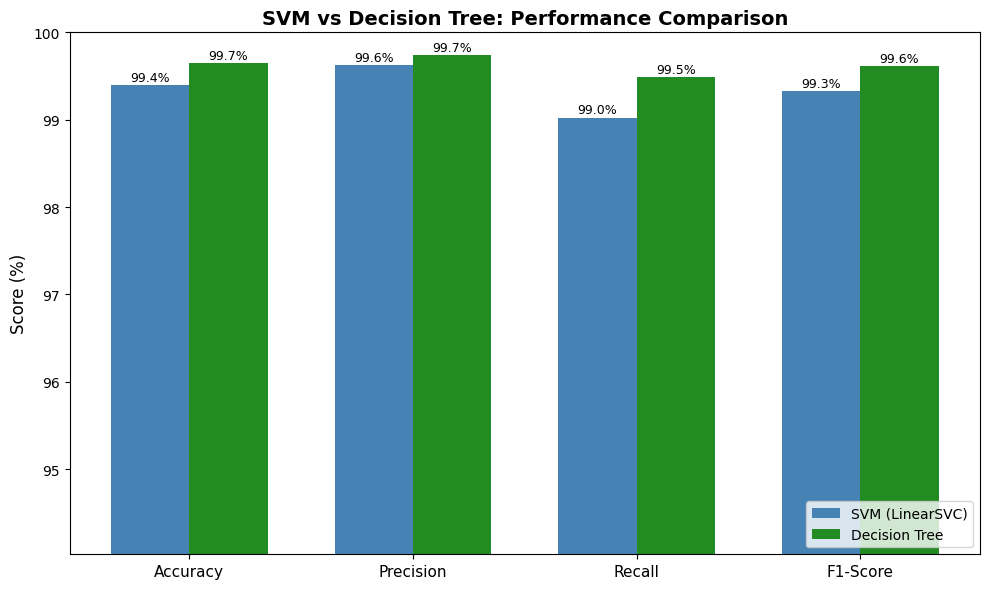

Performance chart: /content/drive/MyDrive/archive/performance_comparison.png


In [ ]:
#Performance Comparison Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
svm_scores = [svm_accuracy*100, svm_precision*100, svm_recall*100, svm_f1*100]
dt_scores = [dt_accuracy*100, dt_precision*100, dt_recall*100, dt_f1*100]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, svm_scores, width, label='SVM (LinearSVC)', color='steelblue')
bars2 = ax.bar(x + width/2, dt_scores, width, label='Decision Tree', color='forestgreen')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('SVM vs Decision Tree: Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right')

# Adjust y-axis based on scores
min_score = min(min(svm_scores), min(dt_scores))
ax.set_ylim(max(0, min_score - 5), 100)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Performance chart: {output_dir}/performance_comparison.png")

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

output_dir = '/content/drive/MyDrive/archive'

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load padded sequences for DL models
X_train_pad = np.load(f'{output_dir}/X_train_pad.npy')
X_val_pad = np.load(f'{output_dir}/X_val_pad.npy')
X_test_pad = np.load(f'{output_dir}/X_test_pad.npy')

# Load labels
y_train_final = np.load(f'{output_dir}/y_train.npy')
y_val = np.load(f'{output_dir}/y_val.npy')
y_test = np.load(f'{output_dir}/y_test.npy')

# Load tokenizer to get vocab size
with open(f'{output_dir}/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

print(f"Data loaded successfully")
print(f"Train: {X_train_pad.shape}")
print(f"Val:   {X_val_pad.shape}")
print(f"Test:  {X_test_pad.shape}")

Data loaded successfully
Train: (24720, 200)
Val:   (6180, 200)
Test:  (7725, 200)


In [ ]:
vocab_size = min(len(tokenizer.word_index) + 1, 5000)
max_length = X_train_pad.shape[1]
embedding_dim = 128

print(f"Model Parameters:")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Max sequence length: {max_length}")
print(f"Embedding dimension: {embedding_dim}")

Model Parameters:
Vocabulary size: 5,000
Max sequence length: 200
Embedding dimension: 128


In [ ]:
# Deep Learning model LSTM
def build_lstm_model():
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length),
        # LSTM layer
        LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
# Build LSTM model
lstm_model = build_lstm_model()
print("LSTM Architecture:")
lstm_model.summary()
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lstm_checkpoint = ModelCheckpoint(
    f'{output_dir}/lstm_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train LSTM
lstm_start_time = time.time()

lstm_history = lstm_model.fit(
    X_train_pad, y_train_final,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, lstm_checkpoint],
    verbose=1
)

lstm_train_time = time.time() - lstm_start_time
print(f"LSTM Training Time: {lstm_train_time:.2f} seconds ({lstm_train_time/60:.2f} minutes)")

LSTM Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6625 - loss: 0.5906
Epoch 1: val_loss improved from inf to 0.58572, saving model to /content/drive/MyDrive/archive/lstm_best.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.6625 - loss: 0.5906 - val_accuracy: 0.6427 - val_loss: 0.5857
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6599 - loss: 0.5797
Epoch 2: val_loss did not improve from 0.58572
387/387 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.6600 - loss: 0.5796 - val_accuracy: 0.7309 - val_loss: 0.6075
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7706 - loss: 0.5298
Epoch 3: val_loss improved from 0.58572 to 0.43129, saving model to /content/drive/MyDrive/archive/lstm_best.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7706 - loss: 0.5297 - val_accuracy: 0.8246 - val_loss: 0.4313
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9215 - loss: 0.2497
Epoch 4: val_loss improved from 0

In [ ]:
#CNN 1D Convolutional
def build_cnn_model():
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length),

        # Convolutional layers (like n-gram feature extraction)
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),

        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),

        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        GlobalMaxPooling1D(),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build CNN model
cnn_model = build_cnn_model()
print("CNN Architecture:")
cnn_model.summary()

# Callbacks for CNN
cnn_checkpoint = ModelCheckpoint(
    f'{output_dir}/cnn_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train CNN
cnn_start_time = time.time()

cnn_history = cnn_model.fit(
    X_train_pad, y_train_final,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, cnn_checkpoint],
    verbose=1
)

cnn_train_time = time.time() - cnn_start_time
print(f"CNN Training Time: {cnn_train_time:.2f} seconds ({cnn_train_time/60:.2f} minutes)")

CNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8502 - loss: 0.2684
Epoch 1: val_loss improved from inf to 0.02544, saving model to /content/drive/MyDrive/archive/cnn_best.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8505 - loss: 0.2680 - val_accuracy: 0.9929 - val_loss: 0.0254
Epoch 2/10
386/387 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0132
Epoch 2: val_loss improved from 0.02544 to 0.00795, saving model to /content/drive/MyDrive/archive/cnn_best.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9968 - loss: 0.0132 - val_accuracy: 0.9981 - val_loss: 0.0079
Epoch 3/10
386/387 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0041
Epoch 3: val_loss did not improve from 0.00795
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9972 - val_loss: 0.0144
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0017
Epoch 4: val_loss did not impro

In [ ]:
#Evaluating deep learning models

def evaluate_dl_model(model, X_test, y_test, model_name):
    """Evaluate a DL model and return metrics"""

    # Inference time
    start_time = time.time()
    y_pred_prob = model.predict(X_test, verbose=0)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Results:")
    print(f"Accuracy:  {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall:    {recall*100:.2f}%")
    print(f"F1-Score:  {f1*100:.2f}%")
    print(f"Inference Time: {inference_time:.2f}s for {len(y_test):,} samples")

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'inference_time': inference_time
    }

# Evaluate both models
lstm_results = evaluate_dl_model(lstm_model, X_test_pad, y_test, "LSTM")
cnn_results = evaluate_dl_model(cnn_model, X_test_pad, y_test, "CNN")

LSTM Results:
Accuracy:  99.43%
Precision: 99.91%
Recall:    98.82%
F1-Score:  99.37%
Inference Time: 57.29s for 7,725 samples
CNN Results:
Accuracy:  99.77%
Precision: 99.77%
Recall:    99.71%
F1-Score:  99.74%
Inference Time: 1.94s for 7,725 samples


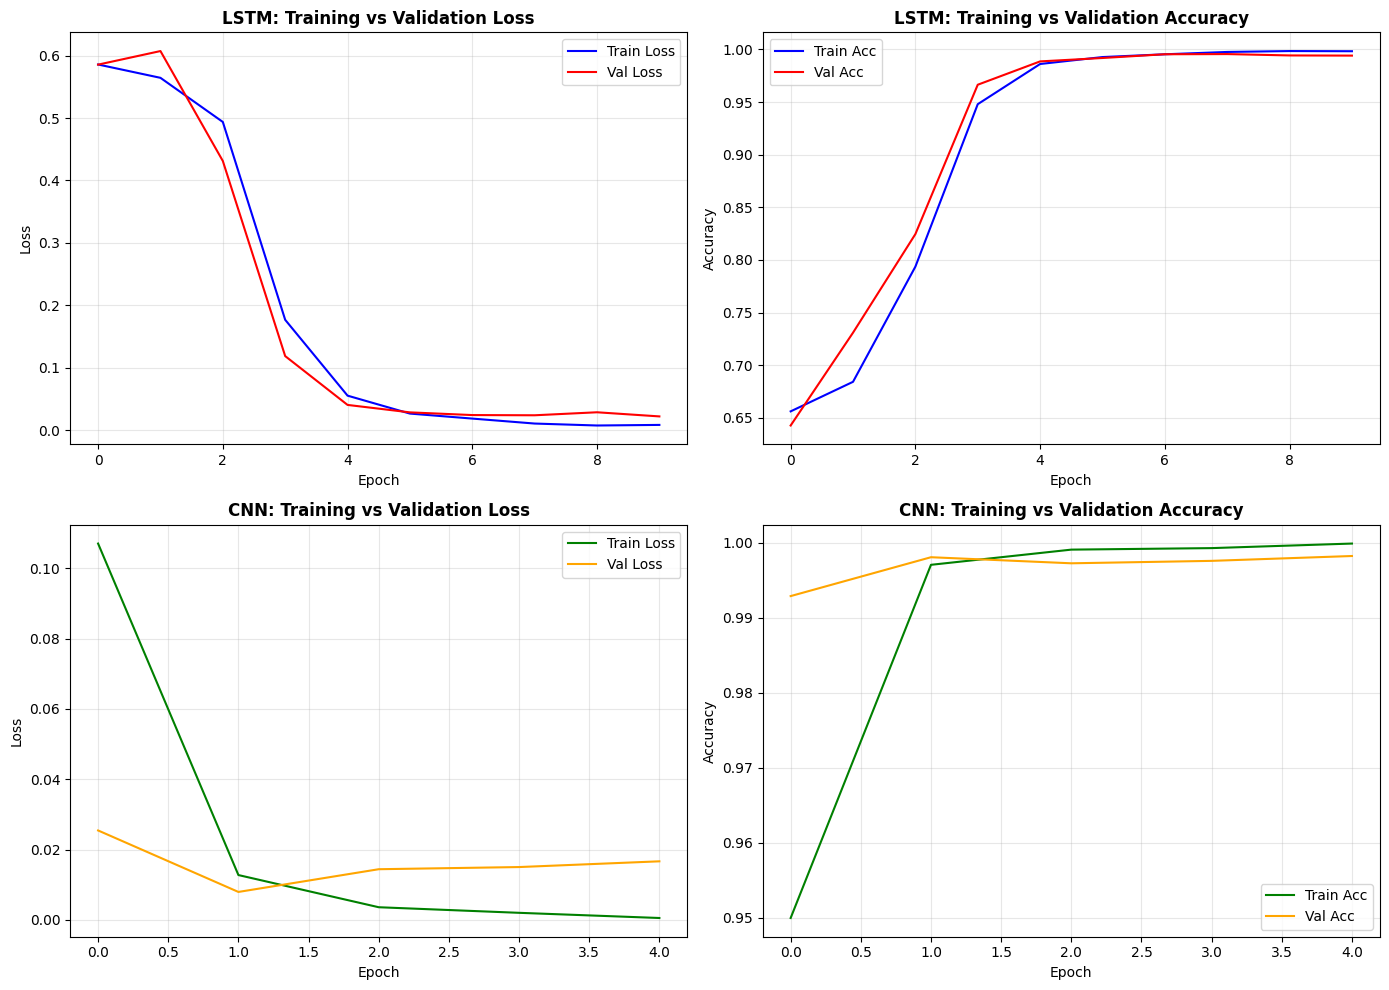

Training history saved: /content/drive/MyDrive/archive/dl_training_history.png


In [ ]:
#Generating Training Plots

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# LSTM Loss
axes[0, 0].plot(lstm_history.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_title('LSTM: Training vs Validation Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LSTM Accuracy
axes[0, 1].plot(lstm_history.history['accuracy'], label='Train Acc', color='blue')
axes[0, 1].plot(lstm_history.history['val_accuracy'], label='Val Acc', color='red')
axes[0, 1].set_title('LSTM: Training vs Validation Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CNN Loss
axes[1, 0].plot(cnn_history.history['loss'], label='Train Loss', color='green')
axes[1, 0].plot(cnn_history.history['val_loss'], label='Val Loss', color='orange')
axes[1, 0].set_title('CNN: Training vs Validation Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# CNN Accuracy
axes[1, 1].plot(cnn_history.history['accuracy'], label='Train Acc', color='green')
axes[1, 1].plot(cnn_history.history['val_accuracy'], label='Val Acc', color='orange')
axes[1, 1].set_title('CNN: Training vs Validation Accuracy', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/dl_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history saved: {output_dir}/dl_training_history.png")

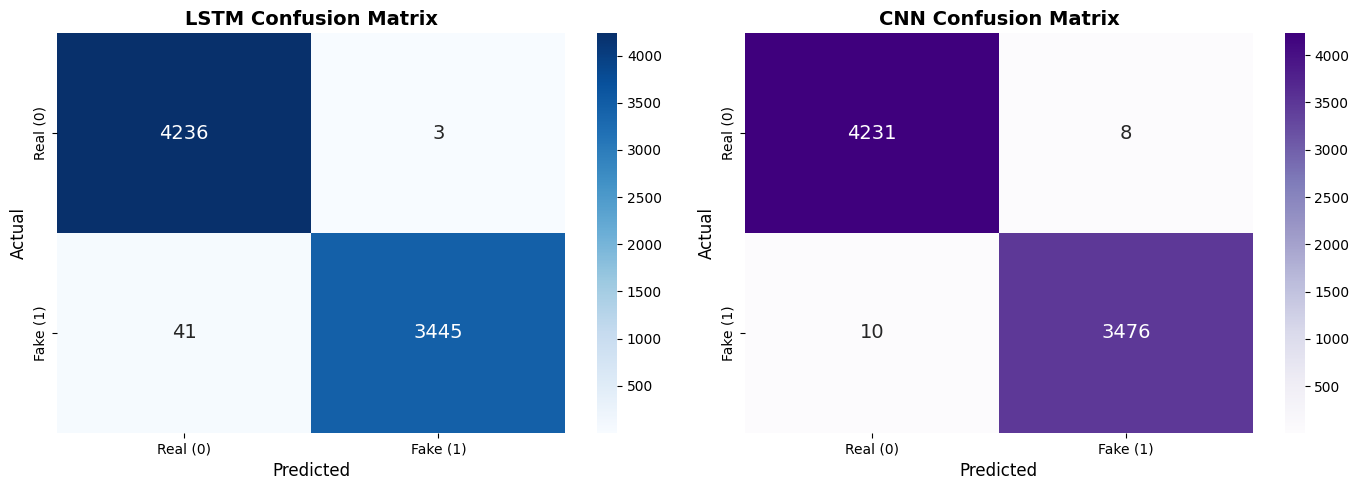

DL confusion matrices saved: /content/drive/MyDrive/archive/dl_confusion_matrices.png


In [ ]:
#DL Models Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM Confusion Matrix
sns.heatmap(lstm_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            annot_kws={'size': 14})
axes[0].set_title('LSTM Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# CNN Confusion Matrix
sns.heatmap(cnn_results['confusion_matrix'], annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            annot_kws={'size': 14})
axes[1].set_title('CNN Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/dl_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"DL confusion matrices saved: {output_dir}/dl_confusion_matrices.png")


In [ ]:
# Save models
lstm_model.save(f'{output_dir}/lstm_model.keras')
cnn_model.save(f'{output_dir}/cnn_model.keras')

print(f"LSTM model saved: {output_dir}/lstm_model.keras")
print(f"CNN model saved: {output_dir}/cnn_model.keras")

# Save training histories
lstm_history_df = pd.DataFrame(lstm_history.history)
cnn_history_df = pd.DataFrame(cnn_history.history)

lstm_history_df.to_csv(f'{output_dir}/lstm_training_history.csv', index=False)
cnn_history_df.to_csv(f'{output_dir}/cnn_training_history.csv', index=False)

print(f"Training histories saved as CSV")

LSTM model saved: /content/drive/MyDrive/archive/lstm_model.keras
CNN model saved: /content/drive/MyDrive/archive/cnn_model.keras
Training histories saved as CSV


In [ ]:
# COMPREHENSIVE MODEL COMPARISON (ML vs DL)
# Load ML results
ml_comparison = pd.read_csv(f'{output_dir}/model_comparison.csv', index_col=0)

# Create full comparison table
all_models_data = {
    'Model': ['SVM (LinearSVC)', 'Decision Tree', 'LSTM', 'CNN'],
    'Type': ['ML', 'ML', 'DL', 'DL'],
    'Accuracy (%)': [
        ml_comparison.loc['SVM (LinearSVC)', 'Accuracy (%)'],
        ml_comparison.loc['Decision Tree', 'Accuracy (%)'],
        round(lstm_results['accuracy'] * 100, 2),
        round(cnn_results['accuracy'] * 100, 2)
    ],
    'Precision (%)': [
        ml_comparison.loc['SVM (LinearSVC)', 'Precision (%)'],
        ml_comparison.loc['Decision Tree', 'Precision (%)'],
        round(lstm_results['precision'] * 100, 2),
        round(cnn_results['precision'] * 100, 2)
    ],
    'Recall (%)': [
        ml_comparison.loc['SVM (LinearSVC)', 'Recall (%)'],
        ml_comparison.loc['Decision Tree', 'Recall (%)'],
        round(lstm_results['recall'] * 100, 2),
        round(cnn_results['recall'] * 100, 2)
    ],
    'F1-Score (%)': [
        ml_comparison.loc['SVM (LinearSVC)', 'F1-Score (%)'],
        ml_comparison.loc['Decision Tree', 'F1-Score (%)'],
        round(lstm_results['f1'] * 100, 2),
        round(cnn_results['f1'] * 100, 2)
    ],
    'Training Time': [
        f'{svm_train_time:.1f}s',
        f'{dt_train_time:.1f}s',
        f'{lstm_train_time:.1f}s',
        f'{cnn_train_time:.1f}s'
    ]
}

full_comparison_df = pd.DataFrame(all_models_data).set_index('Model')

# Display
print("COMPREHENSIVE MODEL COMPARISON (ML vs DL)\n")
print(full_comparison_df)

# Save
full_comparison_df.to_csv(f'{output_dir}/full_model_comparison.csv')
print(f"Saved: {output_dir}/full_model_comparison.csv")

COMPREHENSIVE MODEL COMPARISON (ML vs DL)

                Type  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
Model                                                                         
SVM (LinearSVC)   ML         99.39          99.62       99.02         99.32   
Decision Tree     ML         99.65          99.74       99.48         99.61   
LSTM              DL         99.43          99.91       98.82         99.37   
CNN               DL         99.77          99.77       99.71         99.74   

                Training Time  
Model                          
SVM (LinearSVC)          0.5s  
Decision Tree           19.8s  
LSTM                  5256.6s  
CNN                     26.3s  
Saved: /content/drive/MyDrive/archive/full_model_comparison.csv


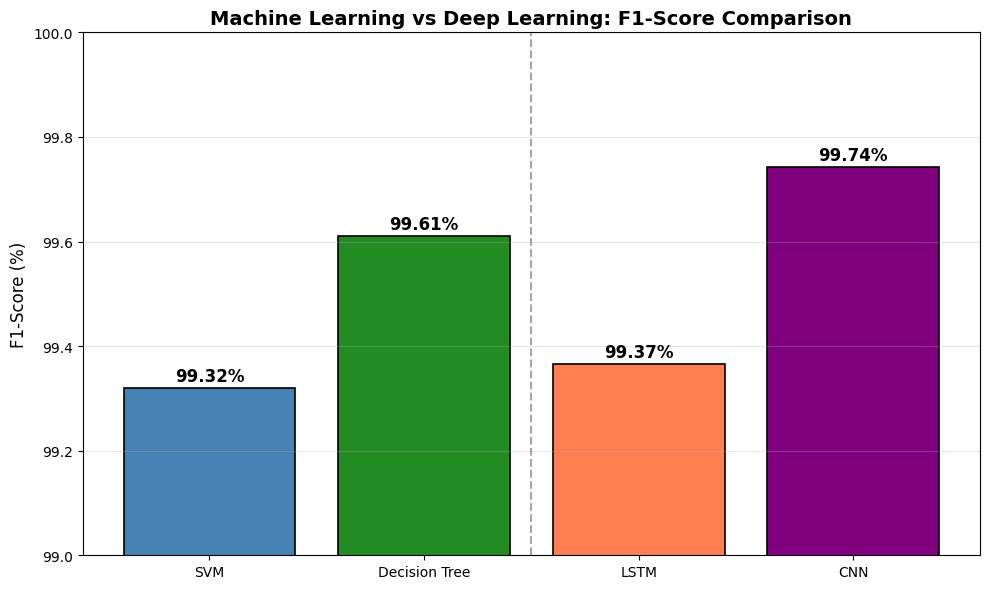

ML vs DL comparison chart saved: /content/drive/MyDrive/archive/ml_vs_dl_comparison.png


In [ ]:
# ML vs DL COMPARISON CHART
models = ['SVM', 'Decision Tree', 'LSTM', 'CNN']
colors = ['steelblue', 'forestgreen', 'coral', 'purple']
f1_scores = [
    float(ml_comparison.loc['SVM (LinearSVC)', 'F1-Score (%)']),
    float(ml_comparison.loc['Decision Tree', 'F1-Score (%)']),
    lstm_results['f1'] * 100,
    cnn_results['f1'] * 100
]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, score in zip(bars, f1_scores):
    ax.annotate(f'{score:.2f}%',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=12, fontweight='bold')

# ML vs DL divider
ax.axvline(x=1.5, color='gray', linestyle='--', alpha=0.7)

ax.set_ylabel('F1-Score (%)', fontsize=12)
ax.set_title('Machine Learning vs Deep Learning: F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(99.0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/ml_vs_dl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ML vs DL comparison chart saved: {output_dir}/ml_vs_dl_comparison.png")

In [ ]:
#XAI (EXPLAINABILITY) ANALYSIS
output_dir = '/content/drive/MyDrive/archive'

# Load TF-IDF vectorizer and data
with open(f'{output_dir}/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# Load ML models
with open(f'{output_dir}/svm_model.pkl', 'rb') as f:
    svm = pickle.load(f)

with open(f'{output_dir}/dt_model.pkl', 'rb') as f:
    dt = pickle.load(f)

# Load test data
X_test_text = np.load(f'{output_dir}/X_test_text.npy', allow_pickle=True)
y_test = np.load(f'{output_dir}/y_test.npy')

# Load TF-IDF test data
from scipy.sparse import load_npz
X_test_tfidf = load_npz(f'{output_dir}/X_test_tfidf.npz')

DECISION TREE FEATURE IMPORTANCE

Top 20 Most Important Features (Decision Tree):
----------------------------------------
 1. reuters              : 0.9812
 2. image via            : 0.0032
 3. century wire         : 0.0024
 4. nov presidential     : 0.0007
 5. factbox              : 0.0007
 6. via                  : 0.0006
 7. saidthe              : 0.0005
 8. via getty            : 0.0005
 9. percent              : 0.0004
10. demographic          : 0.0004
11. democratic           : 0.0004
12. breaking             : 0.0003
13. flickr               : 0.0003
14. carry                : 0.0003
15. made                 : 0.0003
16. avoided              : 0.0003
17. polling              : 0.0003
18. tweeted              : 0.0003
19. south carolina       : 0.0003
20. barack obamas        : 0.0003


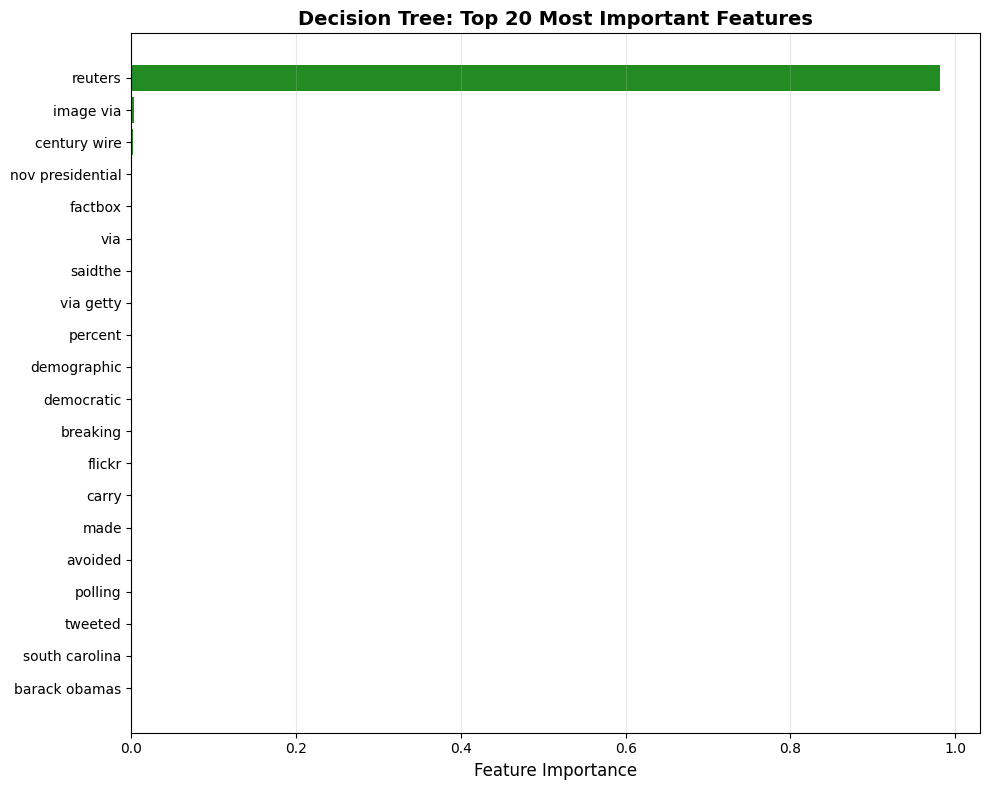


Saved: /content/drive/MyDrive/archive/xai_dt_feature_importance.png


In [ ]:
print("DECISION TREE FEATURE IMPORTANCE")


# Get feature names and importances
feature_names = tfidf.get_feature_names_out()
dt_importances = dt.feature_importances_

# Get top 20 most important features
top_n = 20
top_indices = np.argsort(dt_importances)[-top_n:][::-1]
top_features = [(feature_names[i], dt_importances[i]) for i in top_indices]

print(f"\nTop {top_n} Most Important Features (Decision Tree):")
print("-" * 40)
for i, (feature, importance) in enumerate(top_features, 1):
    print(f"{i:2}. {feature:20} : {importance:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

bars = ax.barh(range(len(features)), importances, color='forestgreen')
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Decision Tree: Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/xai_dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: {output_dir}/xai_dt_feature_importance.png")

SVM TOP PREDICTIVE WORDS

Top 15 Words Predicting FAKE News:
----------------------------------------
 1. via                  : 4.9260
 2. video                : 3.1514
 3. image                : 3.1162
 4. president trump      : 2.9559
 5. breaking             : 2.8239
 6. gop                  : 2.6995
 7. hillary              : 2.3766
 8. image via            : 2.3612
 9. sen                  : 2.0773
10. gov                  : 2.0215
11. saidthe              : 1.9972
12. obama                : 1.8201
13. even                 : 1.8087
14. watch                : 1.7653
15. rep                  : 1.7216

Top 15 Words Predicting REAL News:
----------------------------------------
 1. reuters              : -14.6898
 2. said                 : -5.4237
 3. washington reuters   : -5.1737
 4. president donald     : -2.6530
 5. reuters president    : -2.3988
 6. thats                : -2.2821
 7. factbox              : -2.2813
 8. dont                 : -2.0989
 9. wednesday            : -1.

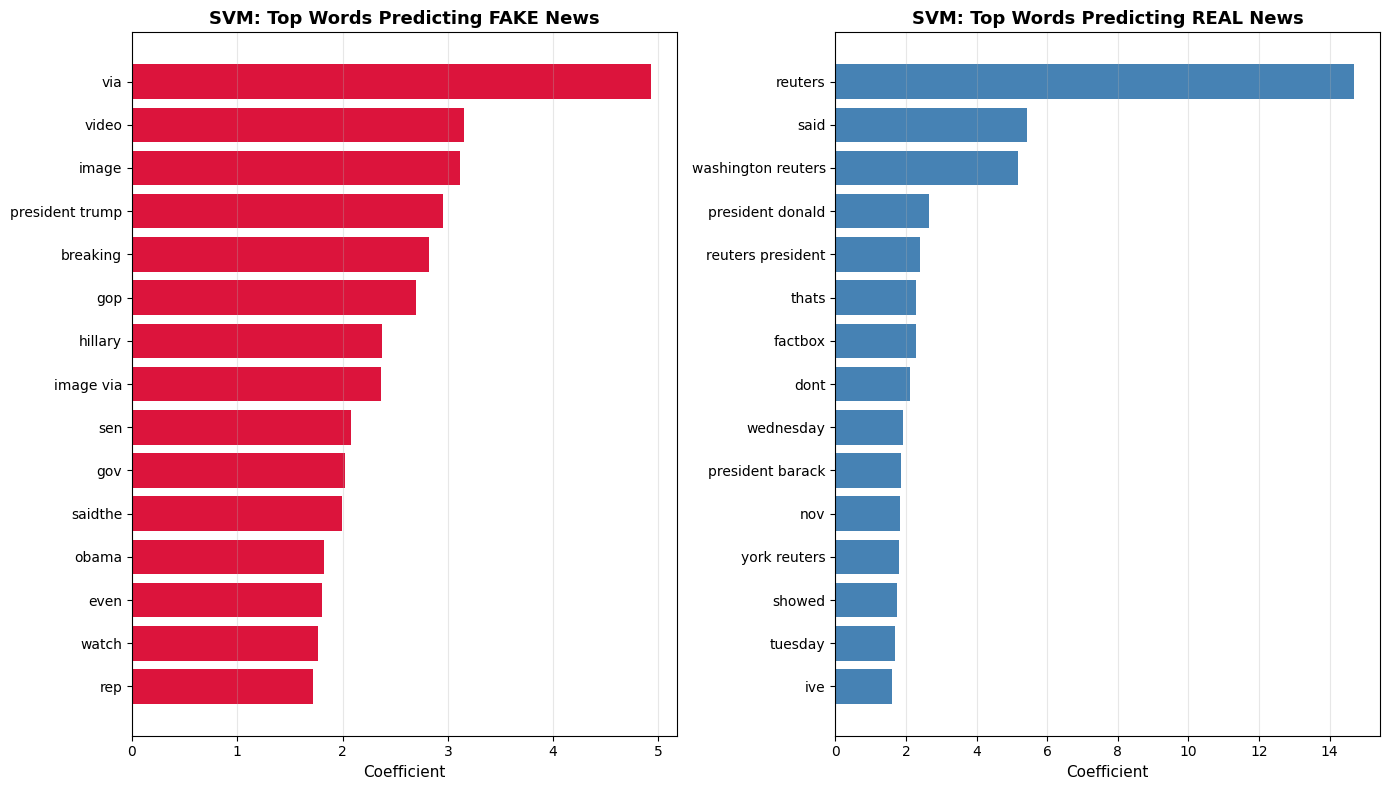


Saved: /content/drive/MyDrive/archive/xai_svm_top_words.png


In [ ]:
print("SVM TOP PREDICTIVE WORDS")

# Get coefficients (for LinearSVC)
svm_coef = svm.coef_[0]

# Top words predicting FAKE news
top_fake_indices = np.argsort(svm_coef)[-15:][::-1]
top_fake_words = [(feature_names[i], svm_coef[i]) for i in top_fake_indices]

# Top words predicting REAL news
top_real_indices = np.argsort(svm_coef)[:15]
top_real_words = [(feature_names[i], svm_coef[i]) for i in top_real_indices]

print(f"\nTop 15 Words Predicting FAKE News:")
print("-" * 40)
for i, (word, coef) in enumerate(top_fake_words, 1):
    print(f"{i:2}. {word:20} : {coef:.4f}")

print(f"\nTop 15 Words Predicting REAL News:")
print("-" * 40)
for i, (word, coef) in enumerate(top_real_words, 1):
    print(f"{i:2}. {word:20} : {coef:.4f}")

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Fake news words
fake_words = [w[0] for w in top_fake_words]
fake_coefs = [w[1] for w in top_fake_words]
axes[0].barh(range(len(fake_words)), fake_coefs, color='crimson')
axes[0].set_yticks(range(len(fake_words)))
axes[0].set_yticklabels(fake_words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Coefficient', fontsize=11)
axes[0].set_title('SVM: Top Words Predicting FAKE News', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Real news words
real_words = [w[0] for w in top_real_words]
real_coefs = [abs(w[1]) for w in top_real_words]  # Use absolute value for visualization
axes[1].barh(range(len(real_words)), real_coefs, color='steelblue')
axes[1].set_yticks(range(len(real_words)))
axes[1].set_yticklabels(real_words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Coefficient', fontsize=11)
axes[1].set_title('SVM: Top Words Predicting REAL News', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/xai_svm_top_words.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: {output_dir}/xai_svm_top_words.png")

In [ ]:
print("LIME EXPLANATIONS (Individual Predictions)")
# Install LIME
try:
    from lime.lime_text import LimeTextExplainer
except ImportError:
    print("Installing LIME...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'lime', '-q'])
    from lime.lime_text import LimeTextExplainer

# Create LIME explainer
explainer = LimeTextExplainer(class_names=['Real', 'Fake'], random_state=42)

# Create prediction function for SVM
def svm_predict_proba(texts):
    """Convert SVM decision function to probabilities"""
    tfidf_vectors = tfidf.transform(texts)
    decisions = svm.decision_function(tfidf_vectors)
    # Convert to pseudo-probabilities using sigmoid
    probs = 1 / (1 + np.exp(-decisions))
    return np.column_stack([1 - probs, probs])

svm_pred = svm.predict(X_test_tfidf)

# Find indices
correct_fake_idx = np.where((y_test == 1) & (svm_pred == 1))[0][0]
correct_real_idx = np.where((y_test == 0) & (svm_pred == 0))[0][0]
misclassified_idx = np.where(y_test != svm_pred)[0][0] if np.any(y_test != svm_pred) else None

print("\nGenerating LIME explanations for sample articles")

# Function to display LIME explanation
def explain_and_display(idx, title):
    text = X_test_text[idx]
    true_label = "FAKE" if y_test[idx] == 1 else "REAL"
    pred_label = "FAKE" if svm_pred[idx] == 1 else "REAL"

    print(f"\n{'='*50}")
    print(f"{title}")
    print(f"{'='*50}")
    print(f"True Label: {true_label}")
    print(f"Predicted:  {pred_label}")
    print(f"Text Preview: {text[:200]}...")

    # Generate explanation
    exp = explainer.explain_instance(text, svm_predict_proba, num_features=10)

    print(f"\nTop 10 Contributing Words:")
    print("-" * 40)
    for word, weight in exp.as_list():
        direction = "→ FAKE" if weight > 0 else "→ REAL"
        print(f"  {word:20} : {weight:+.4f} {direction}")

    return exp

LIME EXPLANATIONS (Individual Predictions)

Generating LIME explanations for sample articles


In [ ]:
exp_fake = explain_and_display(correct_fake_idx, "Correctly Classified FAKE Article")
exp_real = explain_and_display(correct_real_idx, "Correctly Classified REAL Article")

if misclassified_idx is not None:
    exp_wrong = explain_and_display(misclassified_idx, "Misclassified Article")


Correctly Classified FAKE Article
True Label: FAKE
Predicted:  FAKE
Text Preview: man claim gave trump golden shower evidence back video know conservative demanding proof donald trump paid russian lady golden shower honestly enjoy well gentleman gave donald one free provide evidenc...

Top 10 Contributing Words:
----------------------------------------
  video                : +0.0623 → FAKE
  via                  : +0.0217 → FAKE
  know                 : +0.0196 → FAKE
  breaking             : +0.0174 → FAKE
  image                : +0.0168 → FAKE
  trump                : -0.0126 → REAL
  seems                : +0.0097 → FAKE
  gave                 : -0.0088 → REAL
  claim                : +0.0085 → FAKE
  allegedly            : +0.0071 → FAKE

Correctly Classified REAL Article
True Label: REAL
Predicted:  REAL
Text Preview: top democrat house panel say seen controversial intel report washington reuters top democrat house intelligence committee adam schiff said intelligence report vi

In [ ]:
#External Validation
output_dir = '/content/drive/MyDrive/LIAR DATASET'

In [ ]:
#Load LIAR dataset
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
           'barely_true', 'false', 'half_true', 'mostly_true', 'pants_fire', 'venue']

liar_train = pd.read_csv(f'{output_dir}/train.tsv', sep='\t', header=None, names=columns)
liar_test = pd.read_csv(f'{output_dir}/test.tsv', sep='\t', header=None, names=columns)
liar_valid = pd.read_csv(f'{output_dir}/valid.tsv', sep='\t', header=None, names=columns)

print(f"LIAR Dataset Loaded:")
print(f"  Train: {len(liar_train)}")
print(f"  Test:  {len(liar_test)}")
print(f"  Valid: {len(liar_valid)}")

# Combine test + valid for evaluation
liar_eval = pd.concat([liar_test, liar_valid], ignore_index=True)
print(f"  Evaluation set: {len(liar_eval)}")

# Check labels
print(f"\nOriginal labels: {liar_eval['label'].unique()}")

# Convert to binary

fake_labels = ['pants-fire', 'false', 'barely-true']
real_labels = ['half-true', 'mostly-true', 'true']

liar_eval['binary_label'] = liar_eval['label'].apply(
    lambda x: 1 if x in fake_labels else 0
)

print(f"\nBinary label distribution:")
print(f"  Real (0): {(liar_eval['binary_label']==0).sum()}")
print(f"  Fake (1): {(liar_eval['binary_label']==1).sum()}")

# Preprocess text
liar_eval['clean_text'] = liar_eval['statement'].apply(clean_text)

# Remove empty texts
liar_eval = liar_eval[liar_eval['clean_text'].str.strip() != ''].reset_index(drop=True)
print(f"\nAfter cleaning: {len(liar_eval)} statements")

# Check average length
avg_words = liar_eval['clean_text'].apply(lambda x: len(x.split())).mean()
print(f"Average words per statement: {avg_words:.1f}")
print("(Compare to training data: ~300+ words per article)")

LIAR Dataset Loaded:
  Train: 10240
  Test:  1267
  Valid: 1284
  Evaluation set: 2551

Original labels: ['true' 'false' 'half-true' 'pants-fire' 'barely-true' 'mostly-true']

Binary label distribution:
  Real (0): 1382
  Fake (1): 1169

After cleaning: 2551 statements
Average words per statement: 10.5
(Compare to training data: ~300+ words per article)



Features ready:
  TF-IDF shape: (2551, 5000)
  Padded shape: (2551, 200)

EXTERNAL VALIDATION RESULTS - LIAR DATASET

LIAR DATASET RESULTS:
               Accuracy (%)  Precision (%)  Recall (%)  F1 (%)
Model                                                         
SVM                   48.29          46.68       90.25   61.53
Decision Tree         45.94          45.80       97.86   62.39
LSTM                  49.75          47.20       81.52   59.79
CNN                   45.83          45.81       99.66   62.77

Saved: /content/drive/MyDrive/LIAR DATASET/liar_validation_results.csv


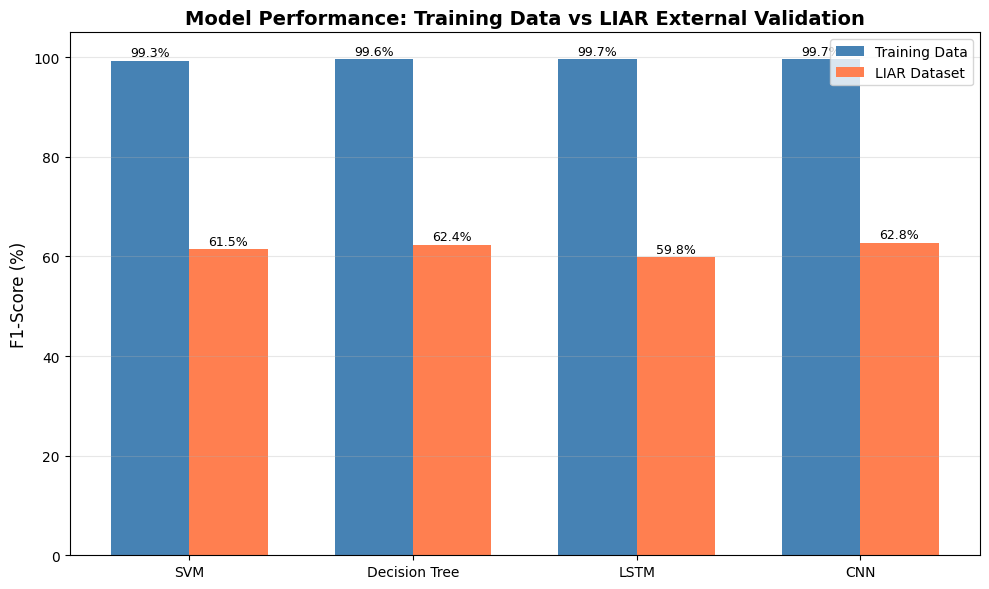

Chart saved: /content/drive/MyDrive/LIAR DATASET/training_vs_liar_comparison.png


In [ ]:
X_liar = liar_eval['clean_text'].values
y_liar = liar_eval['binary_label'].values

# TF-IDF for ML models
X_liar_tfidf = tfidf.transform(X_liar)

# Sequences for DL models
X_liar_seq = tokenizer.texts_to_sequences(X_liar)
X_liar_pad = pad_sequences(X_liar_seq, maxlen=max_length, padding='post', truncating='post')

print(f"\nFeatures ready:")
print(f"  TF-IDF shape: {X_liar_tfidf.shape}")
print(f"  Padded shape: {X_liar_pad.shape}")

# EVALUATE ALL MODELS ON LIAR


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n" + "="*60)
print("EXTERNAL VALIDATION RESULTS - LIAR DATASET")
print("="*60)

results = []

# SVM
y_pred_svm = svm.predict(X_liar_tfidf)
results.append({
    'Model': 'SVM',
    'Accuracy': accuracy_score(y_liar, y_pred_svm),
    'Precision': precision_score(y_liar, y_pred_svm, zero_division=0),
    'Recall': recall_score(y_liar, y_pred_svm, zero_division=0),
    'F1': f1_score(y_liar, y_pred_svm, zero_division=0)
})

# Decision Tree
y_pred_dt = dt.predict(X_liar_tfidf)
results.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_liar, y_pred_dt),
    'Precision': precision_score(y_liar, y_pred_dt, zero_division=0),
    'Recall': recall_score(y_liar, y_pred_dt, zero_division=0),
    'F1': f1_score(y_liar, y_pred_dt, zero_division=0)
})

# LSTM
y_pred_lstm_prob = lstm_model.predict(X_liar_pad, verbose=0)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()
results.append({
    'Model': 'LSTM',
    'Accuracy': accuracy_score(y_liar, y_pred_lstm),
    'Precision': precision_score(y_liar, y_pred_lstm, zero_division=0),
    'Recall': recall_score(y_liar, y_pred_lstm, zero_division=0),
    'F1': f1_score(y_liar, y_pred_lstm, zero_division=0)
})

# CNN
y_pred_cnn_prob = cnn_model.predict(X_liar_pad, verbose=0)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()
results.append({
    'Model': 'CNN',
    'Accuracy': accuracy_score(y_liar, y_pred_cnn),
    'Precision': precision_score(y_liar, y_pred_cnn, zero_division=0),
    'Recall': recall_score(y_liar, y_pred_cnn, zero_division=0),
    'F1': f1_score(y_liar, y_pred_cnn, zero_division=0)
})

# Create results DataFrame
liar_results_df = pd.DataFrame(results)
liar_results_df['Accuracy (%)'] = (liar_results_df['Accuracy'] * 100).round(2)
liar_results_df['Precision (%)'] = (liar_results_df['Precision'] * 100).round(2)
liar_results_df['Recall (%)'] = (liar_results_df['Recall'] * 100).round(2)
liar_results_df['F1 (%)'] = (liar_results_df['F1'] * 100).round(2)

liar_results_df = liar_results_df[['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 (%)']]
liar_results_df = liar_results_df.set_index('Model')

print("\nLIAR DATASET RESULTS:")
print(liar_results_df)


# Save results
liar_results_df.to_csv(f'{output_dir}/liar_validation_results.csv')
print(f"\nSaved: {output_dir}/liar_validation_results.csv")


# COMPARISON CHART: TRAINING vs LIAR

fig, ax = plt.subplots(figsize=(10, 6))

models = ['SVM', 'Decision Tree', 'LSTM', 'CNN']
x = np.arange(len(models))
width = 0.35

# Training F1 scores
train_f1 = [99.32, 99.61, 99.37, 99.74]

# LIAR F1 scores
liar_f1 = liar_results_df['F1 (%)'].values.tolist()

bars1 = ax.bar(x - width/2, train_f1, width, label='Training Data', color='steelblue')
bars2 = ax.bar(x + width/2, liar_f1, width, label='LIAR Dataset', color='coral')

ax.set_ylabel('F1-Score (%)', fontsize=12)
ax.set_title('Model Performance: Training Data vs LIAR External Validation', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/training_vs_liar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart saved: {output_dir}/training_vs_liar_comparison.png")

In [ ]:
import os

output_dir = '/content/drive/MyDrive/archive'

# Model sizes
svm_size = os.path.getsize(f'{output_dir}/svm_model.pkl') / (1024 * 1024)
dt_size = os.path.getsize(f'{output_dir}/dt_model.pkl') / (1024 * 1024)
lstm_size = os.path.getsize(f'{output_dir}/lstm_model.keras') / (1024 * 1024)
cnn_size = os.path.getsize(f'{output_dir}/cnn_model.keras') / (1024 * 1024)

# Inference times
start = time.time()
_ = svm.predict(X_test_tfidf)
svm_inference = time.time() - start

start = time.time()
_ = dt.predict(X_test_tfidf)
dt_inference = time.time() - start

# Create resource table
resource_data = {
    'Model': ['SVM', 'Decision Tree', 'LSTM', 'CNN'],
    'Training Time': [f'{svm_train_time:.1f}s', f'{dt_train_time:.1f}s', f'{lstm_train_time:.1f}s', f'{cnn_train_time:.1f}s'],
    'Inference Time': [f'{svm_inference:.3f}s', f'{dt_inference:.3f}s', f'{lstm_results["inference_time"]:.3f}s', f'{cnn_results["inference_time"]:.3f}s'],
    'Model Size (MB)': [f'{svm_size:.2f}', f'{dt_size:.2f}', f'{lstm_size:.2f}', f'{cnn_size:.2f}']
}

resource_df = pd.DataFrame(resource_data).set_index('Model')
print("\nRESOURCE USAGE COMPARISON:")
print(resource_df)

resource_df.to_csv(f'{output_dir}/resource_comparison.csv')
print(f"\nSaved: {output_dir}/resource_comparison.csv")


RESOURCE USAGE COMPARISON:
              Training Time Inference Time Model Size (MB)
Model                                                     
SVM                    0.5s         0.003s            0.04
Decision Tree         19.8s         0.008s            0.01
LSTM                5256.6s        57.289s            9.49
CNN                   26.3s         1.937s            8.31

Saved: /content/drive/MyDrive/archive/resource_comparison.csv
